In [1]:
%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')
sys.path.append('../models')

import glob

import matplotlib.pyplot as plt

from bbox_utils import generate_default_boxes, convert_to_box_form

from dataGenerator import DataGenerator
from classification_loss import SSDLoss

import numpy as np

import tensorflow as tf

import cv2

In [2]:
from SSD_VGG16 import buildSSD_VGG16

In [3]:
VGG_16 = buildSSD_VGG16(model_checkpoint='checkpoints/SSD_model_7000_img_augs_100_iters_round2')

2022-09-11 04:46:22.845850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 04:46:22.856291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 04:46:22.857015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 04:46:22.858081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
feature_map_shapes = [37, 18, 9, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)
boxes = convert_to_box_form(prior_boxes)

val_image_path = '/home/usman/workspace/fisheye_images/rgb_images/'
val_label_path = '/home/usman/workspace/fisheye_images/box_2d_annotations/'

val_file_names = glob.glob('/home/usman/workspace/fisheye_images/box_2d_annotations/*.txt')

val_list_IDs = [f.split('/')[-1].replace('.txt', '') for f in val_file_names]

val_list_IDs = val_list_IDs

In [5]:
validation_data = DataGenerator(val_list_IDs, 
                   val_label_path,
                   val_image_path, 
                   prior_boxes,
                   boxes,
                  batch_size=32)

In [35]:
for d in validation_data:
    holdout = d
    break

In [36]:
pred = VGG_16.predict(holdout[0])

1/1 [==============================] - 0s 46ms/step


In [37]:
hold = holdout[0].copy()

In [38]:
conf_loss = pred[1]

In [138]:
image_number = 18
conf_loss_max = []

for i, conf in enumerate(conf_loss[image_number]):
#     print(conf)
    conf_loss_max.append([np.max(conf[1:]), np.argmax(conf[1:]), i])
    
conf_loss_max.sort(reverse=True)

In [139]:
g_cx_pred = pred[0][:,:,0] * prior_boxes[:,2] / 10 + prior_boxes[:,0]

g_cy_pred =  pred[0][:,:,1] * prior_boxes[:,3] / 10 + prior_boxes[:,1]

g_w_pred = tf.exp(pred[0][:,:,2] / 5) * prior_boxes[:,2]

g_h_pred = tf.exp(pred[0][:,:,3] / 5) * prior_boxes[:,3]

g_x_min = g_cx_pred - g_w_pred / 2
g_y_min = g_cy_pred - g_h_pred / 2

g_x_max = g_cx_pred + g_w_pred / 2
g_y_max = g_cy_pred + g_h_pred / 2

In [140]:
# tf.transpose(g_x_min, perm=(0,1))

g_x_min_t = tf.transpose(tf.expand_dims(g_x_min, axis = 0), perm=(1,2,0))
g_y_min_t = tf.transpose(tf.expand_dims(g_y_min, axis = 0), perm=(1,2,0))

g_x_max_t = tf.transpose(tf.expand_dims(g_x_max, axis = 0), perm=(1,2,0))
g_y_max_t = tf.transpose(tf.expand_dims(g_y_max, axis = 0), perm=(1,2,0))

In [141]:
g_pred = tf.concat([g_x_min_t, g_y_min_t, g_x_max_t, g_y_max_t], axis = 2)

In [142]:
print(conf_loss.shape)
print(g_pred.shape)

(32, 8096, 6)
(32, 8096, 4)


In [143]:
selected_indices = tf.image.non_max_suppression(
                g_pred[image_number], 
                tf.reduce_max(conf_loss[image_number][:,1:], axis = 1), 
                max_output_size=10,
                iou_threshold=0.5,
                score_threshold=0.5)

In [144]:
selected_boxes = tf.gather(g_pred[image_number], selected_indices)

In [145]:
selected_boxes.shape[0]

5

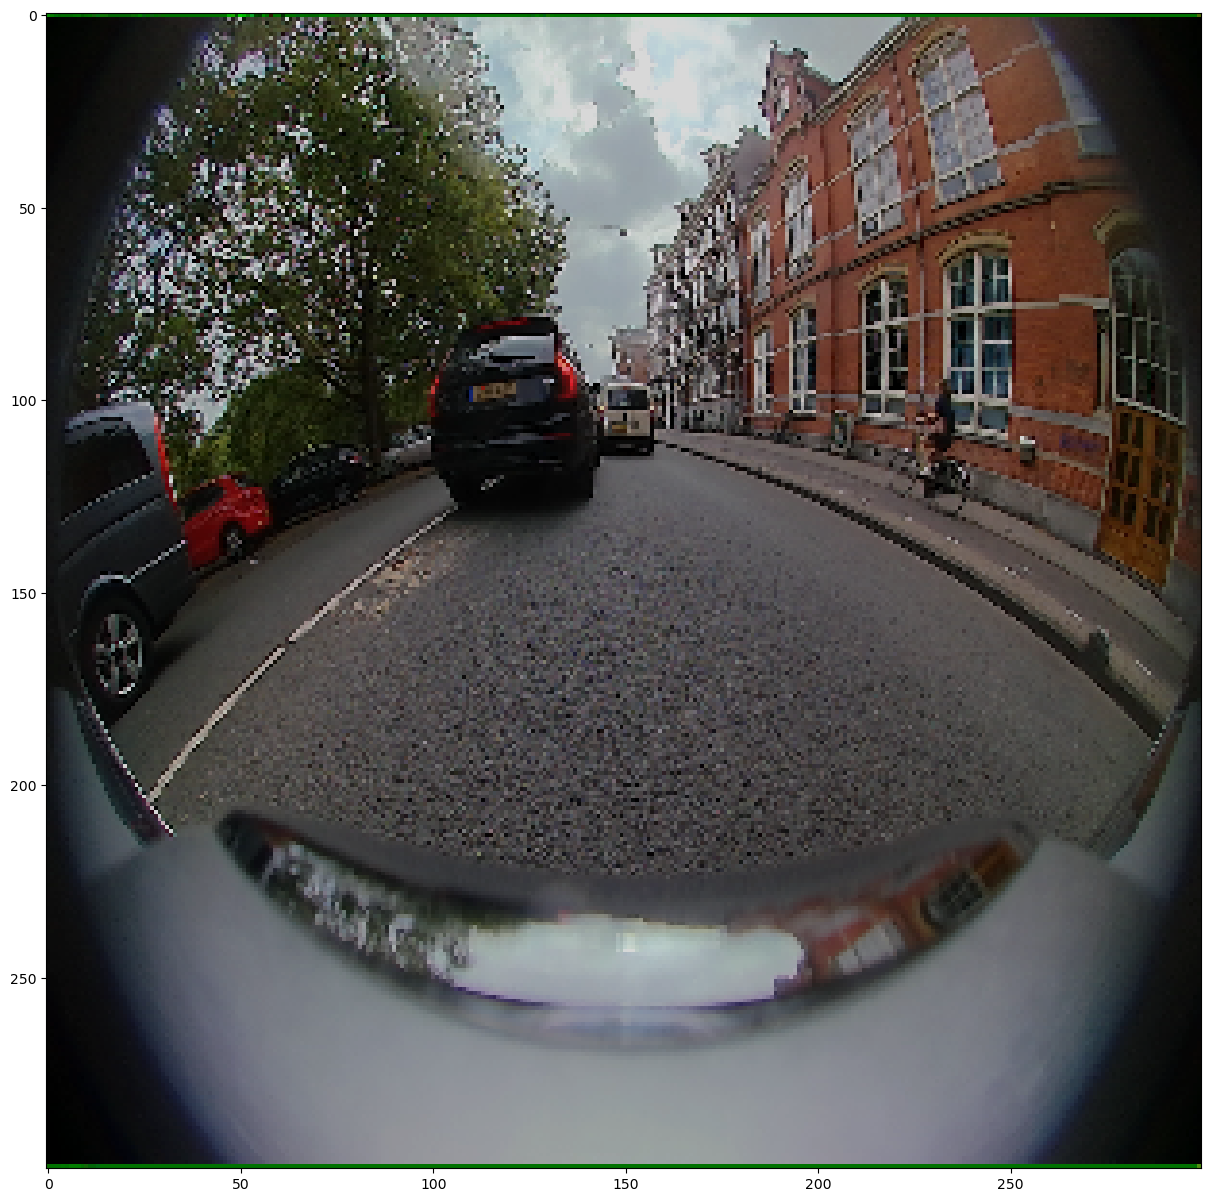

In [146]:
image = hold[image_number].copy()

image = image * 255

image = image.astype(np.int32)

plt.figure(figsize=(15, 15))

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


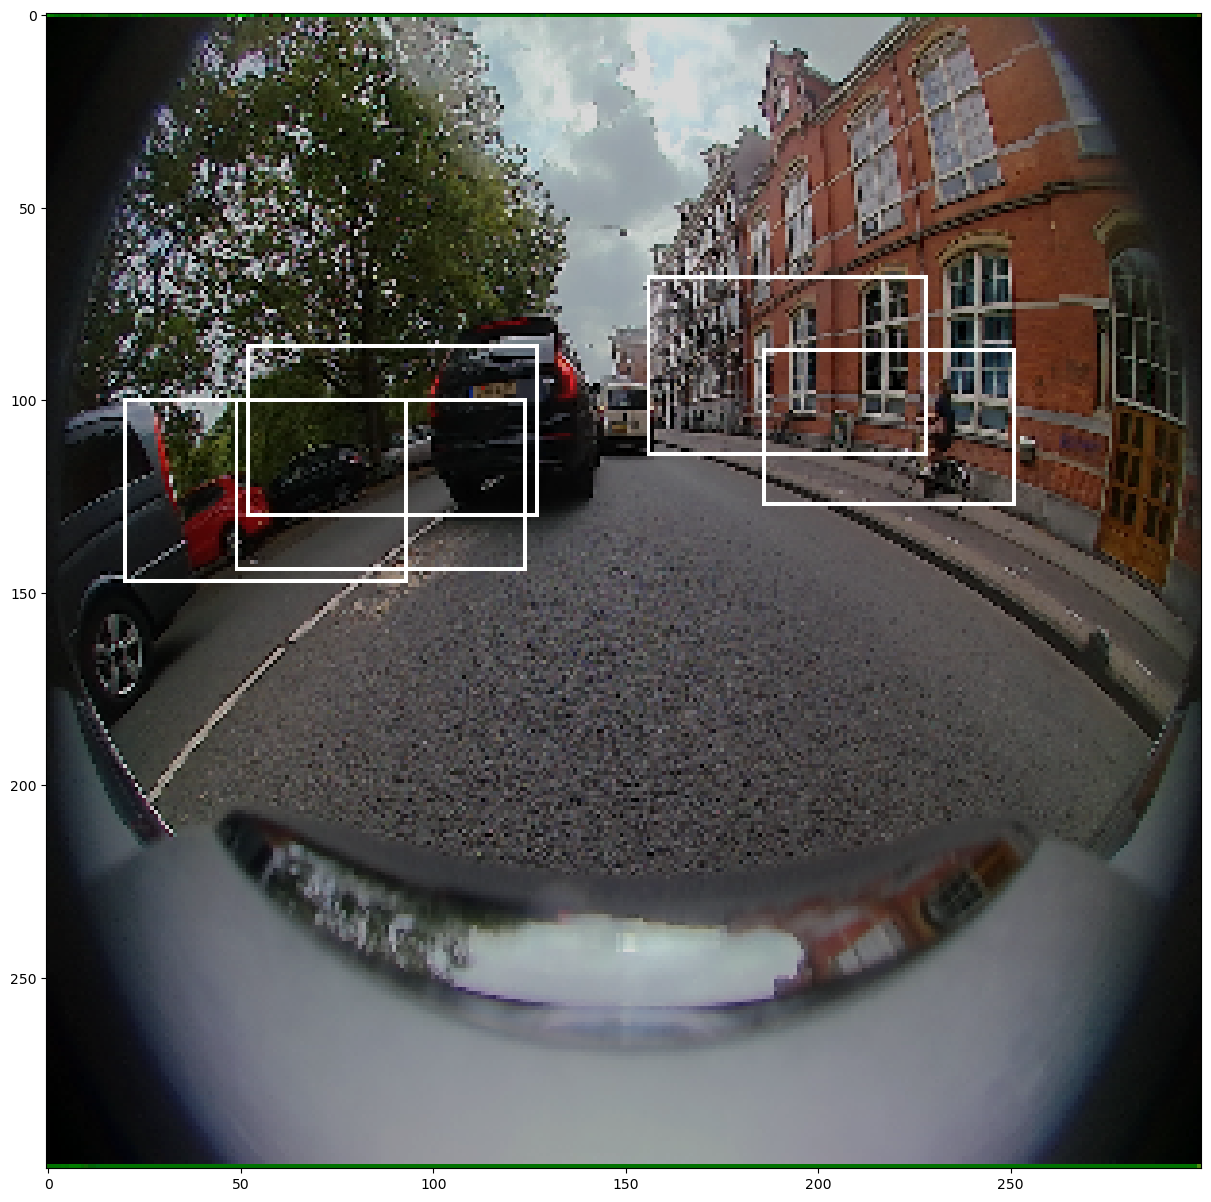

In [147]:
i = conf_loss_max[0][2]

image = hold[image_number][:]

for i in range(selected_boxes.shape[0]):
    
    start_x, start_y, end_x, end_y = selected_boxes[i].numpy() * 300

#     start_x, start_y, end_x, end_y = g_x_min[image_number][i].numpy() * 300, g_y_min[image_number][i].numpy() * 300, g_x_max[image_number][i].numpy() * 300, g_y_max[image_number][i].numpy() * 300

    start_x, start_y, end_x, end_y = int(start_x), int(start_y), int(end_x), int(end_y)

    cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color=(255,10,10), thickness = 1)

plt.figure(figsize=(15, 15))


plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


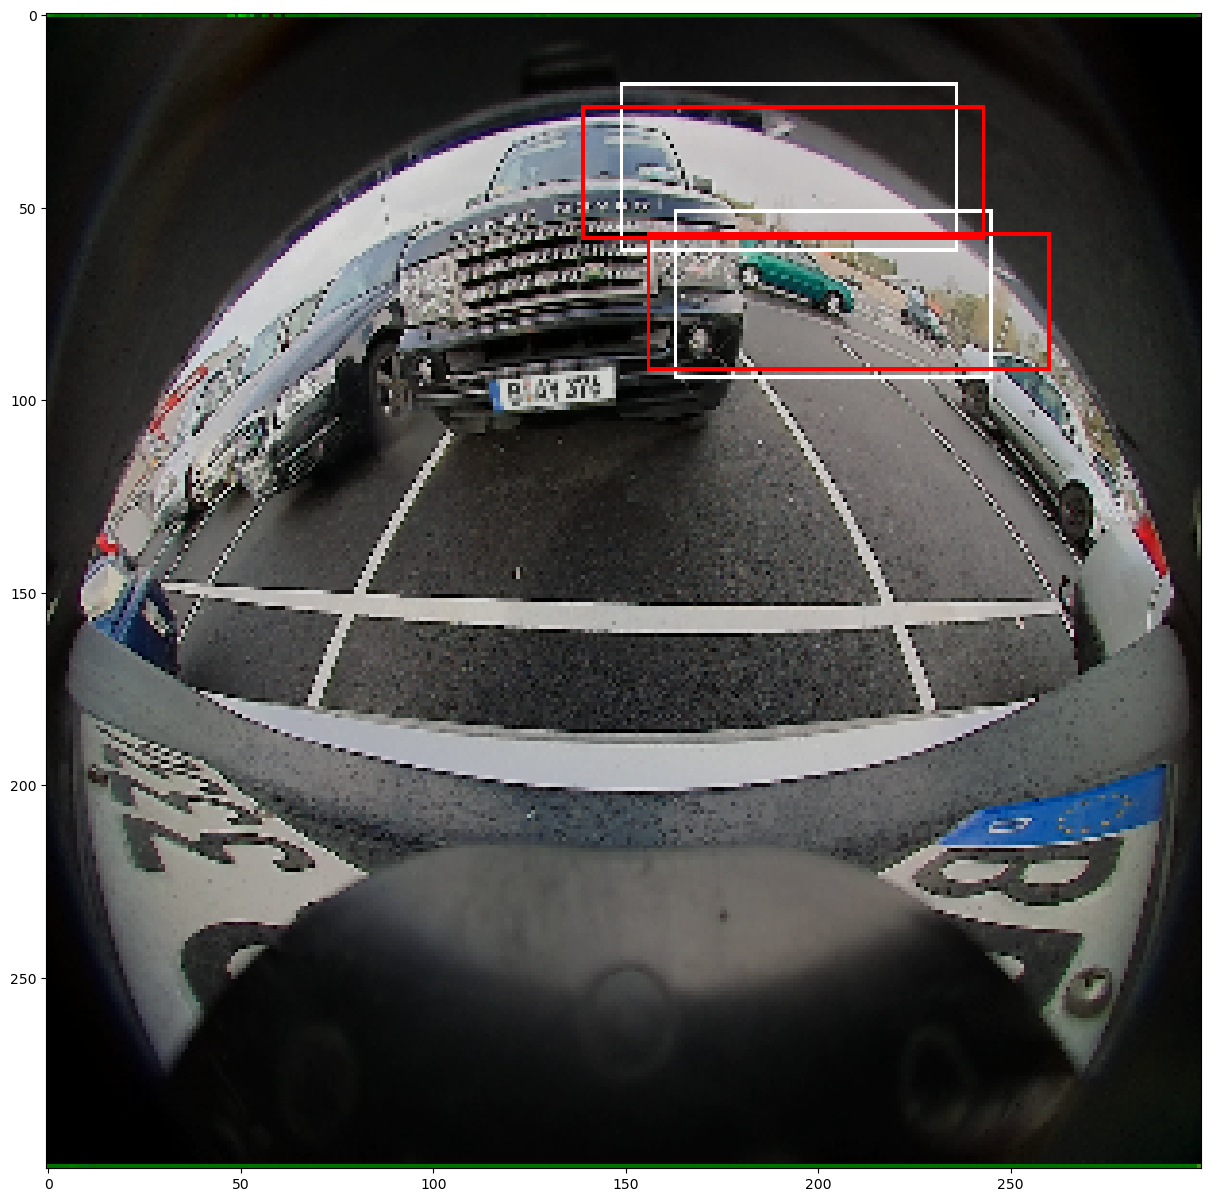

In [67]:
i = conf_loss_max[0][2]

image = hold[image_number][:]

for rank in range(selected_boxes.shape[0]):
    
    i = conf_loss_max[rank][2]

    start_x, start_y, end_x, end_y = boxes[i].numpy() * 300

    start_x, start_y, end_x, end_y = int(start_x), int(start_y), int(end_x), int(end_y)

    cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color=(255,0,0), thickness = 1)

plt.figure(figsize=(15, 15))


plt.imshow(image)